In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy.misc import derivative
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import random
import matplotlib
import nbimporter
from _create_pdf import create_spins;
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes
#matplotlib.pyplot.switch_backend('nbAgg')
#%qtconsole

Importing Jupyter notebook from _create_pdf.ipynb
Importing Jupyter notebook from _helper_functions.ipynb
Importing Jupyter notebook from _steady_state.ipynb
Importing Jupyter notebook from _mbes.ipynb
Importing Jupyter notebook from _do_calculation.ipynb


In [2]:
gcoll = 1.98596327e+01
q = 2.448741
quali = 914
fr = 3.2981e3;
kappa = np.pi*fr/quali #HWHM
delta = 0*2*np.pi #detuning cavity to spin central frequency ws-wc
deltac = 0*2*np.pi #detuning drive to cavity wc-wp
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 1.28912544e+01
nbins = 701#701#5000#20
#g0 = gcoll/sqrt(nspins)
print(kappa)

11.33619992429376


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse

def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund
    
    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002)*(1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse

def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    #xint = np.linspace(0, tend, nfcomps)
    
    #spline = interpolate.BSpline(xint, fcomps, 2)
    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)

    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004)*(1-logistic.cdf(t, loc=tend-0.02, scale=0.004))
    
    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq, spline

def pulse_rwa_const_spline(t, args):
    wgrund = args[0]
    spline = args[1]
    maxampl = args[2]
    
    tend = np.pi/wgrund
    
    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004)*(1-logistic.cdf(t, loc=tend-0.02, scale=0.004))
    
    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq


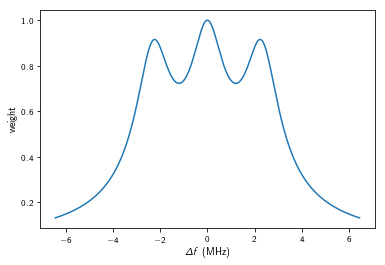

In [4]:
spins, gs, pdf = create_spins(gcoll, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)

plt.figure()
plt.plot(spins, pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

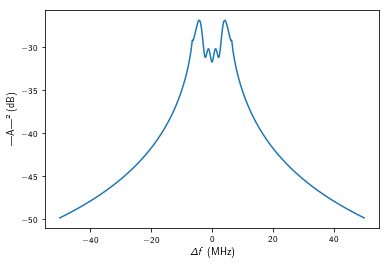

In [5]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [6]:
pumptime = 400e-3#5*np.pi/gcoll
decaytime = 500e-3
dt = 4e-3 #The time resolution of the AWG. Don't change that because the solution of the MBEs are written in a way that use that as time resolution
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)

# test time it takes to calculate


init = np.ones(nbins*2+1)*(-1)
init[0] = 0
init[1::2] = 0

### Calibrate power

In [7]:
pulsei = np.ones((len(tlist)))

pin = np.arange(-30, 0,0.5)
aref = 740

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack((np.real(asolpump[:,2::2]), np.real(asoldecay[:,2::2])))
    small[ctr, :, :] = np.vstack((np.real(asolpump[:,1::2]), np.real(asoldecay[:,1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

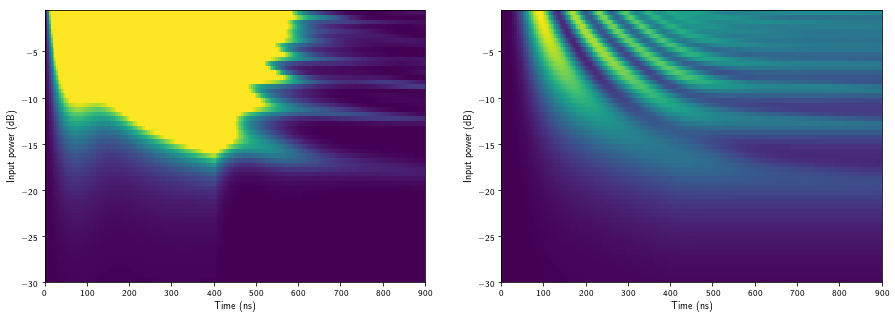

In [8]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.pcolor(tplot, pin, alos, vmin=0, vmax=60)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');

ax2.pcolor(tplot, pin, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');

### Linear Rabi oscillations

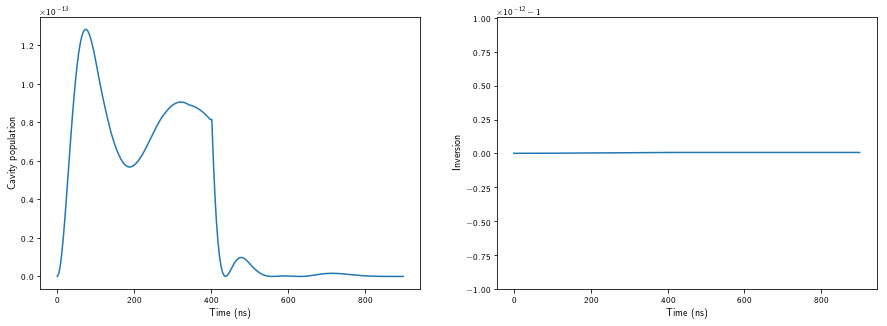

In [9]:
alos = np.zeros((len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))

asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, 0.00001, kappa, deltac, gs, gperp, spins, gpar)
alos = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
szlos = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
                  
                  
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(tplot, alos)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Cavity population');

ax2.plot(tplot, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion');

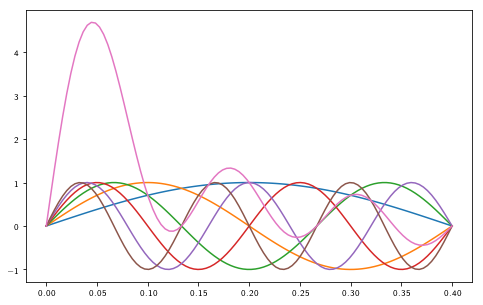

In [10]:
number_fcp = 6
ttest = np.linspace(0,pumptime,numsteps)
wgrund = np.pi/ttest[-1]
sumsin = np.zeros((number_fcp, len(ttest)))

fig, ax = plt.subplots(1,1, figsize=(8,5))

for i in range(number_fcp):
    sumsin[i, :] = np.sin(wgrund*ttest*(i+1))
    ax.plot(ttest, sumsin[i,:])
ax.plot(ttest, np.sum(sumsin, axis=0))
maxfourier = max(np.sum(sumsin, axis=0))

In [11]:
class GRAPE:
    
    def __init__(self):
        self.tp = np.arange(0,0.34+dt,dt)
        self.td = np.arange(0, decaytime+dt, dt)
        self.number_fcp = number_fcp
        self.max_ampl = 739.99982973
        self.max_t_ampl = aref
        self.target_time_decay = 0.1 #when after switching off the pulse the inversion should be maximum
        self.wgrund = np.pi/self.tp[-1]
        self.plot_handle = None
        self.counter = 0
        self.solution = None
        self.fcomps = None
        self.fitness = 0
        self.vars = []
        self.fig = None
        self.disp1 = display(Markdown(""), display_id='0')
        self.disp2 = display(Markdown(""), display_id='1')
        self.best_fitness = 1.
        self.epsilon = -0.1
        self.target_fitness = 0.1
        self.dummy_fitness = []
        self.dummy_solution = []
        self.grad_idx = -1
        self.pulse = None
        self.gradients = np.zeros(np.shape(self.tp))
        
    def fitness_func(self, x, *args):
        tidx = args[0]
        pulse = args[1][:]
        ichan = args[2]
        
        init = np.ones(nbins*2+1)*(-1)
        init[0] = 0
        init[1::2] = 0
        
        
        pi = pulse[:]
        pi[tidx] = x

        pulsei, pulseq = pulse_rwa_const_spline(self.tp, args=(self.wgrund, pulse, self.max_ampl))

        fitness, solution = self.calculate_fitness(pulsei, pulseq)
        
        self.dummy_fitness.append(fitness)
        self.dummy_solution.append(solution)
        return fitness
    
        
    def adjust_gradient(self, t, pulse, iquad=True):
        self.gradients = np.zeros(np.shape(t))
        pn = pulse[:]
        tl = np.arange(len(t))
        random.shuffle(tl)
        ctr = 1
        for i in tl:
            k = pn[i].copy()
            gra = scipy.misc.derivative(self.fitness_func, k, dx=abs(self.epsilon), args=((i, pn.copy(), True)))
            self.gradients[i] = gra
            
            
            self.grad_idx = i

            self.plot_stuff(self.fitness, self.solution, self.pulse, self.gradients)
            self.disp2.update(Markdown("### Current value: %i of %d; Current fitness: %f; Gradient: %f" %(ctr, len(self.tp), 1-self.dummy_fitness[1], gra)))
            self.dummy_fitness = []
            self.dummy_solution = []
            pn[i] = pulse[i] + self.epsilon*self.gradients[i]*40
            ctr += 1
        return pn.copy()
        
        
        
    def main(self, initial=None):
        t = datetime.datetime.now()
        self.filename_save = "/home/andreas/Physik/nelder_mead/grape_%s"%t.strftime("%Y-%m-%d %H:%M:%S")
        filename_save = self.filename_save
        pumpt = pumptime*100
        if initial is None:
            self.pulsei, self.pulseq, spline = pulse_rwa_gauss_const(self.tp, (self.wgrund, np.random.uniform(-0, np.pi*2/self.number_fcp, (self.number_fcp)), self.max_ampl))
            init = spline[:]
        else:
            init = initial
            self.pulsei, self.pulseq = pulse_rwa_const_spline(self.tp, args=(self.wgrund, init, self.max_ampl))
        
        self.pulse = init.copy()
        while self.best_fitness > self.target_fitness:
            self.fitness, self.solution = self.calculate_fitness(self.pulsei, self.pulseq)
            self.grad_idx = -1
            self.plot_stuff(self.fitness, self.solution, self.pulse, self.gradients)
            self.pulse = self.adjust_gradient(self.tp, self.pulse)
            self.pulsei, self.pulseq = pulse_rwa_const_spline(self.tp, args=(self.wgrund, self.pulse, self.max_ampl))
            self.counter += 1
            
            if self.fitness < self.best_fitness:
                savedict = {'wgrund': self.wgrund, 'time': self.tp, 'timedecay': self.td, 'pulse':np.vstack((self.pulsei, self.pulseq)), 'solution': self.solution, 'fitness': self.fitness, 'nbins':nbins, 'gammaq':gammaq,'gpar': gpar, 'gperp':gperp, 'deltac': deltac, 'delta':delta, 'kappa':kappa,'gs':gs, 'spline': self.pulse, 'gradients':self.gradients}
            
                pulseforsave = np.zeros((len(self.tp), 3))
                pulseforsave[:,0] = self.tp
                pulseforsave[:,1] = self.pulsei
                pulseforsave[:,2] = self.pulseq
                savedict2 = {'wgrund': self.wgrund, 'puls': pulseforsave}
                if self.fitness < 0.5:
                    scipy.io.savemat(self.filename_save, savedict)
                    scipy.io.savemat(self.filename_save + '_simple', savedict2)
                self.best_fitness = self.fitness
            
        
    
   
    def plot_stuff(self, fitness, solution, pulse, gradients):
        if not self.fig:
            self.fig, ((ax1, ax0), (ax2, ax3)) = plt.subplots(2,2,figsize=(15,10))
        else:
            ax1, ax0, ax2, ax3 = self.fig.axes
            ax0.clear()
            ax1.clear()
            ax2.clear()
            ax3.clear()
            gc.collect()
        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        pos3 = ax3.get_position()
        pos0 = ax0.get_position()
        pos1n = [pos2.x0, pos1.y0,  pos1.width, pos1.height] 
        
        
        ax1.plot(self.tp*1000, self.pulsei, 'b-')
        ax1.plot(self.tp*1000, self.pulseq, 'g-')
        
        ax0.plot(self.tp*1000, self.gradients, 'b-')
        ax0.set_ylabel('Gradient')
        ax0.set_xlabel("Time (ns)")
        
        
        szsol = np.real(np.sum(solution[:, 2::2], axis=1))
        asol = solution[:,0]
        
        ax1.plot(self.tp*1000, np.sqrt(self.pulsei**2+self.pulseq**2), 'k--')
        ax1.set_ylabel("Amplitude (a.u.)")
        ax1.set_xlabel("Time (ns)")        
        ax1.plot(self.tp*1000, self.max_ampl*pulse/max(abs(pulse)), 'r.')
        ax1.plot(self.tp*1000, self.max_ampl*pulse/max(abs(pulse)), 'r-')
        if self.grad_idx > -1:
            ax1.plot(self.tp[self.grad_idx]*1000, self.max_ampl*pulse[self.grad_idx]/max(abs(pulse)), 'k.')
        ax1.set_ylim([-self.max_t_ampl-50, self.max_t_ampl+50])
        ax1.set_xlim([-20, 20+self.tp[-1]*1000])
        ax2.plot(self.tp*1000, (szsol[:len(self.tp)]), 'r-')
        ax2.plot(self.td*1000+self.tp[-1]*1000, szsol[len(self.tp):], 'k-')
        ax2.set_ylabel("Inversion")
        ax2.set_xlabel("Time (ns)")
        ax2.set_ylim([-1,1])
        ax3.plot(self.tp*1000, abs(asol[:len(self.tp)])**2, 'g-')
        ax3.plot(self.td*1000+self.tp[-1]*1000, abs(asol[len(self.tp):])**2, 'm-')
        ax3.set_ylabel("|A|²")
        ax3.set_xlabel("Time (ns)")
        ax1.set_position(pos1n)
        plt.close('all')
        if not self.plot_handle:
            self.plot_handle = display(self.fig, display_id='plot')
        else:
            self.plot_handle.update(self.fig)
        idx = np.abs(self.td - self.target_time_decay).argmin()
        self.disp1.update(Markdown("### Generation %i; Inversion: %f; Fitness: %f" %(self.counter, max(np.real(np.sum(solution[:, 2::2], axis=1))[len(self.tp)+idx:]), 1-fitness)))
        


            
    def calculate_fitness(self, pulsei, pulseq):

        init = np.ones(nbins*2+1)*(-1)
        init[0] = 0
        init[1::2] = 0
        
        solutionpump, solutiondecay, infodict = solve_mbes(mbes_soc, init, pdf, self.tp, self.td, pulsei, pulseq, self.tp, kappa, deltac, gs, gperp, spins, gpar)

        max_p_ampl = max(np.sqrt(self.pulsei**2+self.pulseq**2))

        solution = np.vstack((solutionpump, solutiondecay))
        idx = np.abs(self.td - self.target_time_decay).argmin()
        inversion = np.real(np.sum(solutiondecay[idx:, 2::2], axis=1))
        maxinv = max(inversion)
        idxinv = int(np.where(inversion==maxinv)[0])
        maxcav = max(abs(solutiondecay[:,0])**2)
        cavity_photons = (abs(solutiondecay[idxinv+idx,0])**2)/maxcav
        fitness = (1-max(inversion)) # + cavity_photons
        
        #small numbers are better!!
        
        return fitness, solution

### Generation 459; Inversion: 0.873924; Fitness: 0.873924

### Current value: 17 of 86; Current fitness: 0.873924; Gradient: -0.000003

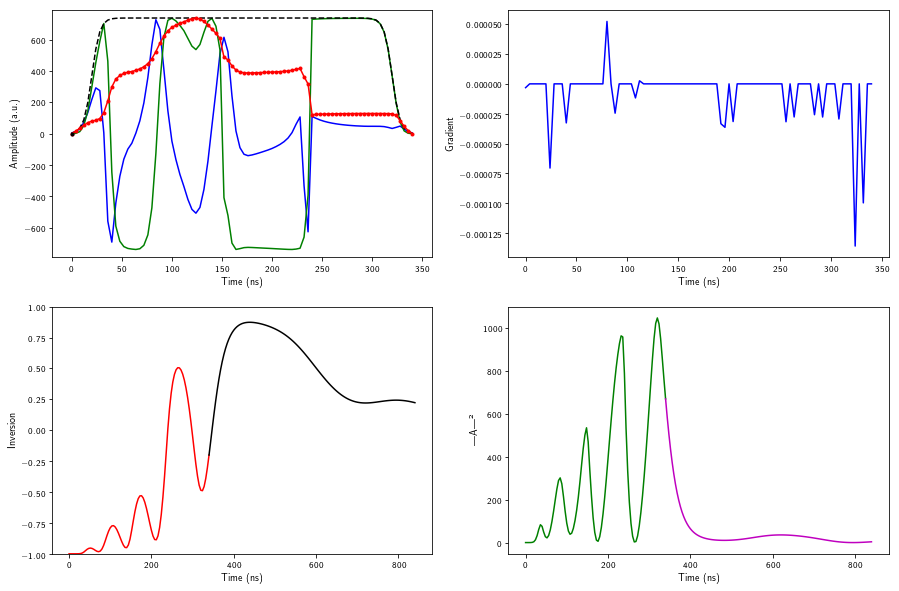

In [ ]:
init = array([ 2.76901073e-03, 1.64447337e-01, 3.30674462e-01, 4.94832097e-01,
        6.26268959e-01, 7.24806906e-01, 8.67565407e-01, 1.19338327e+00,
        1.84042070e+00, 2.71417066e+00, 3.46633834e+00, 3.91458982e+00,
        4.17221743e+00, 4.37198256e+00, 4.52885319e+00, 4.66040290e+00,
        4.82299927e+00, 5.00037313e+00, 5.21022119e+00, 5.47317643e+00,
        5.81701932e+00, 6.23778302e+00, 6.70418409e+00, 7.13156167e+00,
        7.49090992e+00, 7.77839522e+00, 7.98967977e+00, 8.18697325e+00,
        8.36441428e+00, 8.55490042e+00, 8.71862010e+00, 8.81765013e+00,
        8.80866621e+00, 8.66744945e+00, 8.39492444e+00, 7.96213627e+00,
        7.45570228e+00, 6.90537100e+00, 6.21114504e+00, 5.65397321e+00,
        5.19864511e+00, 4.83898909e+00, 4.60251169e+00, 4.46376912e+00,
        4.39678609e+00, 4.39406066e+00, 4.41123460e+00, 4.44507513e+00,
        4.48238726e+00, 4.51342359e+00, 4.55113791e+00, 4.58687937e+00,
        4.61694849e+00, 4.65045723e+00, 4.67554793e+00, 4.68633827e+00,
        4.66713529e+00, 4.54905316e+00, 4.15983543e+00, 3.55318111e+00,
        1.76005151e+00, 1.35203200e+00, 1.31572455e+00, 1.32094485e+00,
        1.33771726e+00, 1.35792756e+00, 1.37536560e+00, 1.39089123e+00,
        1.40394874e+00, 1.41381692e+00, 1.42212454e+00, 1.42809149e+00,
        1.43216330e+00, 1.43467457e+00, 1.43375123e+00, 1.42852460e+00,
        1.41682849e+00, 1.39737770e+00, 1.36195213e+00, 1.29268383e+00,
        1.14149613e+00, 8.80434519e-01, 5.98375768e-01, 3.67253700e-01,
        1.76449095e-01, 1.23144311e-03])

gg = GRAPE()
gg.main(initial= init)